# Notebook for moisture transport project 

**TO DO**

- get hourly data for all variables (new hard disk?)
- solve diagnostic calculation of moisture divergence


**First steps**
- create timeseries with anomalies for P, E and moisture transport (MFC)
- wavelet analysis on hourly precip data 
- decomposition of MFC in eddy and mean flow 
- decomposition in thermodynamic and dynamic component 


**Next steps:**
- do the same for WRF or HAR data 
- do the same for extreme events on different time scales 
- do the same events for extreme events on different spatial scales 


##  vertically integrated moisture flux divergence from q and wind fields 

- get moisture divergent fields for every single summer season and calculate the mean of divergences 
- column integration of divergence fields 
- deviation to monthly means for eddy decomposition 
- from mixing ratio/specific humidity (kg/kg) to mm/day (or kg/m3) using density of dry air: pd = p/RT (ideal gas law )

## Calculation functions

In [3]:
# import libraries 
import numpy as np 
import xarray as xr
import metpy 
from metpy import calc
import scipy as sp
import scipy.signal
from scipy.signal import convolve
import matplotlib.pyplot as plt
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors

**Basics**

In [562]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def geopotential_to_height(z):
    """ This function converts geopotential heights to geometric heights. This approximation takes into account the varying gravitational force with heights, but neglects latitudinal vairations.
    Parameters:
    ------------
    z(float) : (1D or multi-dimenstional) array with geopotential heights
    Returns:
    ----------
    geometric_heights : array of same shape containing altitudes in metres
    """
    g = 9.80665 # standard gravity 
    Re = 6.371 * 10**6  # earth radius
    geometric_heights   = (z*Re) / (g * Re - z)
    return geometric_heights 


def column_integration(values, z, ax = None ):
    """This functions calculates the column-integrated value of a given atmospheric variable at different pressure levels
    Parameters:
    -----------
    values(float): 1D or multi-dimensional array with values of atmospheric variable at different pressure levels
    z(int): array with geopotential heights for values
    axis = axis along which to integrated. The default is 0.
    Returns:
    --------
    colint(float): array with column-integrated values of variable (dimension reduced by 1)
    """
    # convert geopotential to geometric heights in meters 
    geometric_heights   = geopotential_to_height(z)

    if ax == None:
        ax = 0

    # integration of column values
    colint = np.trapz(values, x= geometric_heights, axis =ax )

    return colint

**Constants**

In [168]:
from metpy.units import units

# assign unit to grid spacing
Rad = 6371*1000
# gravitational accelration 
g = 9.8 
# density of water in kg/m3 
pw= 997
# density for dry air 
pd = 1.225 
# specific gas constant for dry air 
R = 287.058

## grid spacings 
dx = 2*np.pi*Rad * (0.25/360)
# latitude dependent 
dy = 2*np.pi*Rad *(0.25/360) * np.cos(np.nanmean(lats))*(-1)
dx = dx * units.meters
dy = dy * units.meters
# constant for unit in mm per day 
C= -1/(g*pw)
c= -1/(g)

**Divergence**

In [205]:
## preprocessing of coordinates for convolution 

# creating 2D fields for lats and lons 
latitudes = np.stack([lats]*np.shape(lons)[0], axis = 1)
longitudes = np.stack([lons]*np.shape(lats)[0], axis = 0)

# convert lats and lons to cartesian coordinates 
x = Rad * np.cos(np.radians(latitudes)) * np.cos(np.radians(longitudes))
y = Rad * np.cos(np.radians(latitudes)) * np.sin(np.radians(longitudes))
z = Rad *np.sin(np.radians(latitudes))

# stack to get 3D array 
cartesian = np.stack([x, y, z], axis = 2)
# pythagorean theorem to get distances in meter
dlat = np.sqrt(np.sum((cartesian[2:, :] - cartesian[:-2,:]) ** 2, axis=-1))
dlon = np.sqrt(np.sum((cartesian[:, 2:] - cartesian[:,:-2]) ** 2, axis=-1))


In [33]:
# with convolution 

def dy_dlat(y, dlat):
    k_lat = np.array([[-1], [0], [1]])
    result = convolve(y, k_lat, mode="valid") / dlat
    return result 

def dy_dlon(y, dlon):
    k_lon= np.array([[1, 0, -1]])
    result = convolve(y, k_lon, mode="valid") / dlon
    return result 

## Climatological precipitation and evaporation ERA5 

In [60]:
f= 'cache/era5_clim_1979-1989.nc'
precip = xr.open_dataset(f)
P1979 = precip.tp.values[0]*1000
lsp = precip.lsp.values[0]*1000
cp = precip.cp.values[0]*1000
f= 'cache/era5_clim_evapo_1979-1989.nc'
evapo = xr.open_dataset(f)
E1979 = evapo.e.values[0]* - 1000
f= 'cache/era5_clim_moistdiv_1979-1989.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd1979 = moisture['vimd'].values[0] 

In [61]:
f= 'cache/era5_clim_2010-2019.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
lsp = precip.lsp.values[0]*1000
cp = precip.cp.values[0]*1000
f= 'cache/era5_clim_evapo_2010-2019.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* - 1000
f= 'cache/era5_clim_moistdiv_2010-2019.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd = moisture['vimd'].values[0] 
lats = precip.latitude.values
lons = precip.longitude.values

# check P - E which should be equal to moisture flux divergence 
p_e = P - E 
lcr= E/P

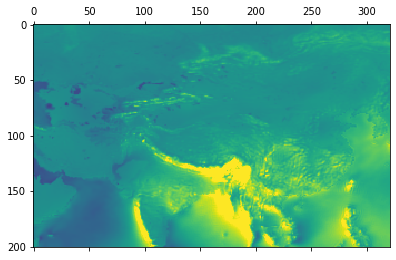

In [15]:
plt.matshow(-vimd, vmin = -10, vmax = 10)

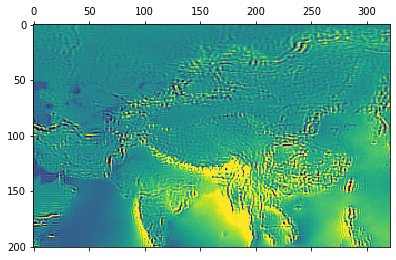

In [16]:
plt.matshow(-moistdiv, vmin = -10, vmax = 10)

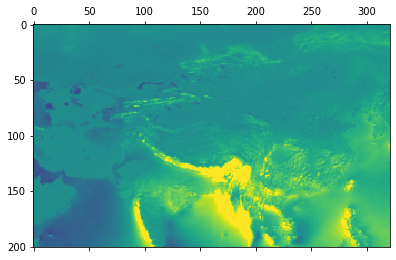

In [17]:
plt.matshow(p_e, vmin = -10, vmax = 10)

In [150]:
mean =(moisture_field/41) * 86400* c
mean.max()

14.013118952985426

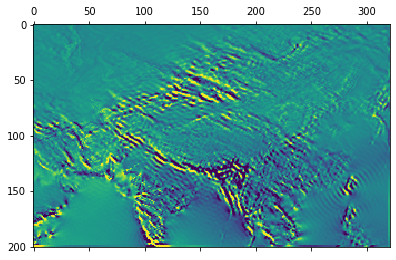

In [146]:
plt.matshow(moisture_field, vmin = -0.01, vmax = 0.01) 

In [7]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values


# mask as coordinates                                                                                                                                          
dem_mask = elevations.where(elevations >= 3000)
dem_mask.coords['mask'] = (('lon', 'lat'), dem_mask)


# global DEM 
dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
elevation = xarray.open_dataset(dem)['elevation']
elevations_tp= elevation[800:1200, 1840:2480]
lat = np.linspace(800,1199,200)
lon= np.linspace(1840,2479,321)
elevs= elevations_tp.interp(nlat= lat, nlon= lon )

In [2180]:
# summer climatology 
f = 'cache/temp.nc'
data = xr.open_dataset(f)
temp = data.t[0]

f = 'cache/era5_summerclim.nc'
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
q = mfields.q[0] 
z = mfields.z[0]

lats= mfields.latitude
lons = mfields.longitude
pressure = mfields.level.values

# get qV field 
qu = q*u 
qv = q*v

## 3. Temporal average over summer seasons 1979 to 2019 

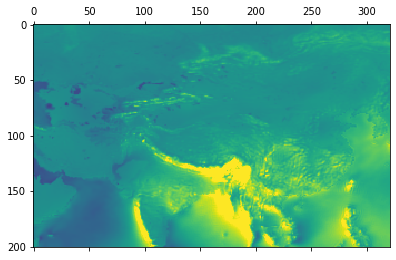

In [134]:
plt.matshow(-vimd, vmin = -10, vmax = 10 )

In [135]:
# based on q 

moisture_field  = np.zeros((201,321))
quint  = np.zeros((201,321))
qvint  = np.zeros((201,321))

for y in np.arange(1979,2020):
    print(y)
    f = 'cache/era5_'+str(y) +'_fields_monmean.nc'
    s = 'cache/era5_'+str(y) +'_clwcciwc.nc'
    t = 'cache/era5_'+str(y) +'_temp.nc'
    pr = 'cache/era5_single-levels-monthly-means_surface_pressure_'+str(y)+'.nc'
    # get variables 
    mfields = xr.open_dataset(f)
    sfield = xr.open_dataset(s)
    tfield = xr.open_dataset(t)
    spdata = xr.open_dataset(pr)
    u = mfields.u[0].values
    v = mfields.v[0].values
    # specific humidity (water vapour in kg/kg)
    q = mfields.q[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    # add specific cloud water and specific cloud ice to get full water 
    clwc = sfield.clwc[0].values
    ciwc = sfield.ciwc[0].values
    q = q +  clwc + ciwc 
    
    z = mfields.z[0].values  
    lats= mfields.latitude.values
    lons = mfields.longitude.values
    pressure = mfields.level.values
    t= tfield.t[0].values
    
    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = find_nearest_idx(pressure, sp_value)
        #if sp_value > pl:
            #idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
    
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d
        
    # get qV fields 
    qu = q*u
    qv = q*v 
    
    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))
    
    # horizontal divergence (unit: kg/m2/s) 
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])
    # sum derivatives along x and y axis to get divergence 
    moisture_field += (udiv + vdiv)
    
    # close open datasets 
    mfields.close()
    sfield.close()
    tfield.close()
    spdata.close()
    


1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [404]:
mdiv = (moisture_field/41)* 86400 

In [402]:
mdiv.max()

14.013118952985426

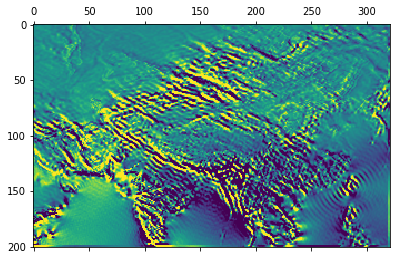

In [405]:
plt.matshow(mdiv, vmin = -10, vmax = 10)

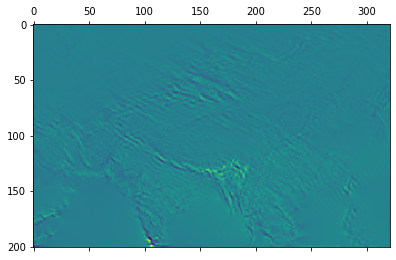

In [173]:
plt.matshow(moisture_field* 86400 * c )

## Example: May 1979 

In [431]:
# Verification: vertically integrated moisture and moisture flux divergence 

f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_mvimdvimdvertical_integral_of_divergence_of_moisture_fluxdivergence_60,50,10,130.nc'
divergence = xr.open_dataset(f)
flux_div = divergence['p84.162'][0] # mean 
moist_div = divergence['vimd'][0] # accumulated 

In [434]:
divergence['p84.162'].units
divergence['vimd'].units

'kg m**-2'

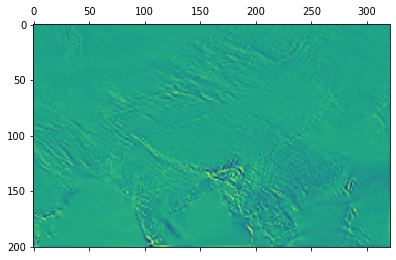

In [142]:
plt.matshow(div)

In [152]:
np.nanmean(div*86400)

-0.5569665329632714

In [151]:
np.nanmean(flux_div*86400)

-0.2954914967655951

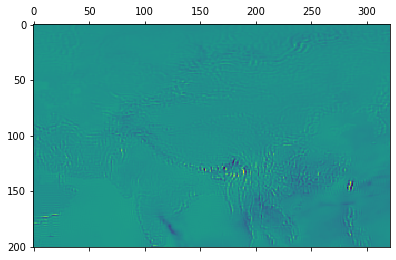

In [143]:
plt.matshow(flux_div)

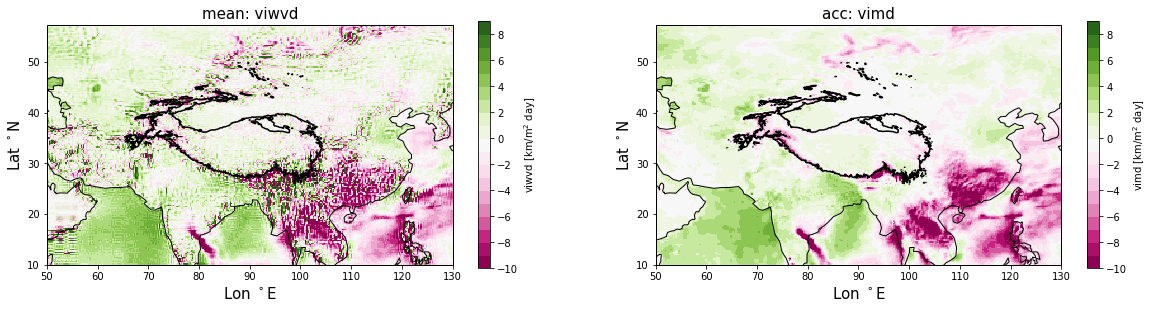

In [99]:

plt.figure(figsize= (20,10))
s= 15


# customizing of colorbar 
cmap=plt.cm.PiYG
#cmap=plt.cm.coolwarm
r = np.arange(-10,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values


ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m1= ax1.pcolormesh(lons, lats, flux_div,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=s)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=s)
ax1.set_title('mean: viwvd', fontsize= s)
plt.colorbar(m1, label = 'viwvd [km/m$^2$ day]')


ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m2= ax2.pcolormesh(lons, lats, moist_div, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_title('acc: vimd', fontsize= s)
ax2.set_ylabel('Lat $^\circ$N',  fontsize= s)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=s)
plt.colorbar(m2, label = 'vimd [km/m$^2$ day]')
plt.savefig('ERA5_vimd_and_viwvd.png')
plt.show()

In [196]:
mfields.close()

f = 'cache/era5_1979_may.nc'
# get variables 
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
# specific humidity (water vapour in g/kg)
sh = mfields.q[0] 
# get geopotential 
z = mfields.z[0].values

# get fields for cloud ice and water 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_ciwvclwc_60,50,10,130.nc'
d = xr.open_dataset(f)
ciwc = d.ciwc[0]
clwc = d.clwc[0]

# effect of surface pressure
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
d = xr.open_dataset(f)
sp = d.sp[0].values/100 

# temperature for unit conversion 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
d = xr.open_dataset(f)
temp = d.t[0].values

q = sh + ciwc + clwc 

In [197]:
# set geopotential to 0, where surface pressure < 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    #if sp_value > pl:
        #idx = idx + 1     
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] = 0

In [198]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*temp[plev])
    m = q[plev] *p_d
    q[plev] = m 

In [199]:
# get qv fields 
qu = q*u
qv = q*v 
 
udiv = np.zeros((37,201,321))
vdiv = np.zeros((37,201,321))

# horizontal divergence
for p in np.arange(37):
    udev = dy_dlon(qu[p], dlon) 
    vdev = dy_dlat(qv[p], dlat) 
    udiv[p] = np.hstack([udev
                         ,np.zeros((201,2))])
    vdiv[p]= np.vstack([vdev, np.zeros((2,321))])

# colummn integration of divergence fields 
quint = column_integration(np.flip(udiv, axis = 0), np.flip(z, axis = 0), ax= 0 )
qvint = column_integration(np.flip(vdiv, axis = 0), np.flip(z, axis = 0), ax = 0 )

# sum derivatives along x and y axis to get divergence 
div= (quint + qvint) 

# x 1/g and conversion to mm per day 
divergence = div * 86400 * c 

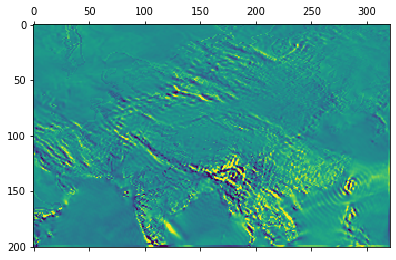

In [129]:
plt.matshow(divergence, vmin = -3, vmax = 3)

In [153]:
# get qv fields 
qu = q*u
qv = q*v 

# colummn integration of divergence fields first
quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0), ax= 0 )
qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0), ax = 0 )

# horizontal divergence

udev = dy_dlon(quint, dlon) 
vdev = dy_dlat(qvint, dlat) 
udiv = np.hstack([udev,np.zeros((201,2))])
vdiv= np.vstack([vdev, np.zeros((2,321))])

# sum derivatives along x and y axis to get divergence 
div= (udiv + vdiv ) 

# x 1/g and conversion to mm per day 
divergence = div * 86400 * c 

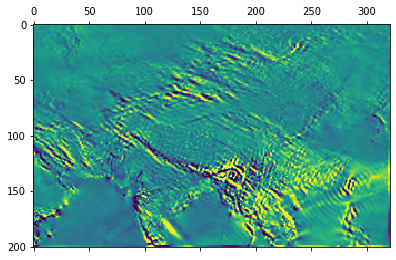

In [106]:
plt.matshow(divergence , vmin = -2, vmax = 2)

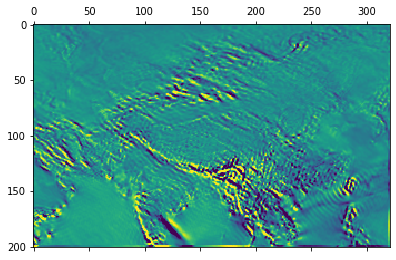

In [114]:
plt.matshow(-diva, vmin = -2, vmax = 2)

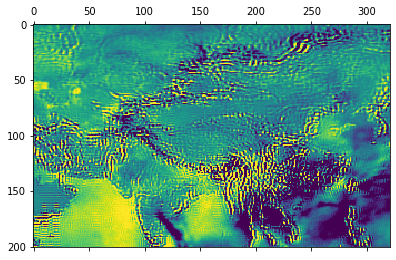

In [113]:
plt.matshow(flux_div, vmin = -5, vmax =5 )

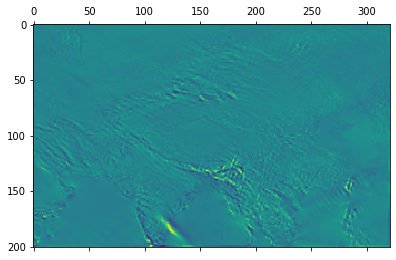

In [208]:
plt.matshow(-mfc*c)

In [220]:
mfd.max()

0.6655248037957869

In [221]:
div_accum.max()

0.598527094030141

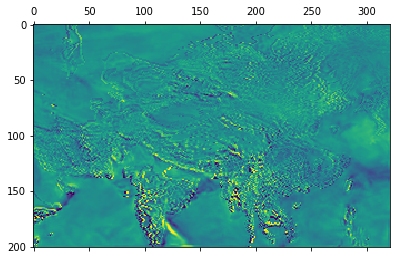

In [201]:
plt.matshow(diva-divergence, vmin = -2,vmax = 2)

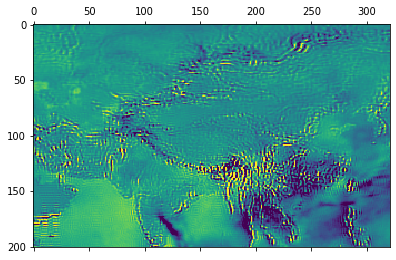

In [71]:
plt.matshow(flux_div, vmin = -10 ,vmax = 10)

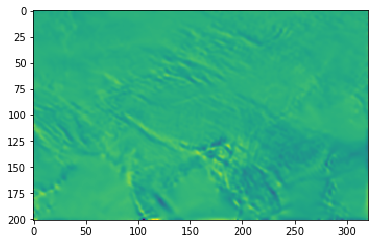

In [114]:
import wrf
smoothed = wrf.smooth2d(-divergence, passes = 5)
plt.imshow(smoothed)

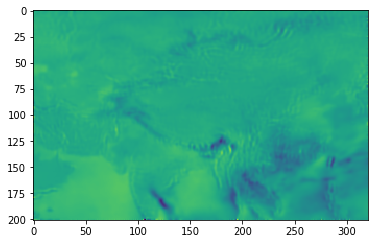

In [115]:
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed)

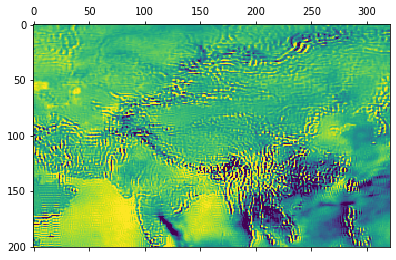

In [2830]:
plt.matshow(flux_div, vmin  = -10, vmax =5)
plt.show()

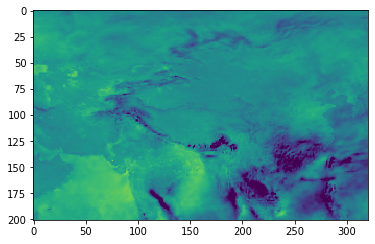

In [72]:
plt.imshow(moist_div, vmin = -10, vmax = 10)

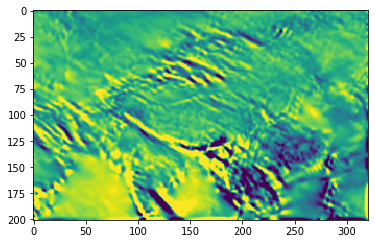

In [179]:
import wrf 
smoothed = wrf.smooth2d(diva, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

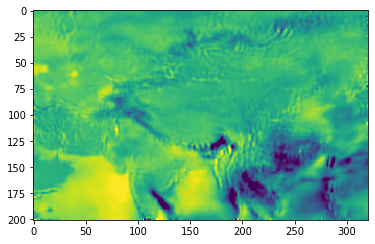

In [2475]:
import wrf 
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

In [2572]:
# with metpy derivate function instead of convolution 
u_d = metpy.calc.first_derivative(quint[:,:-1], axis =  -1, delta = dlon* units.meter) 
v_d = metpy.calc.first_derivative(qvint[:-1,:], axis = -2, delta = dlat* units.meter)

u_d = np.hstack([udev,np.zeros((201,2))])
v_d = np.vstack([vdev, np.zeros((2,321))])

md = ( u_d + v_d)*86400*c


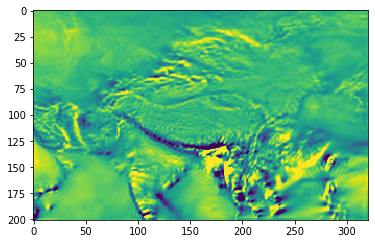

In [2676]:
plt.imshow(div, vmin = -10, vmax = 5)

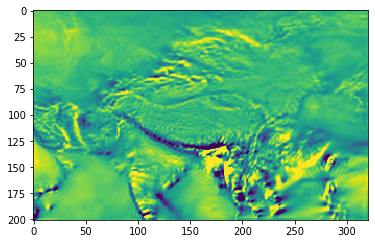

In [2675]:
plt.imshow(-md, vmin = -10, vmax = 5)

-> same result for divergences calculated with convolution for first derivative functions rovided by metpy! 

## May 1979 from hourly data

In [3088]:
# VIMD from may 1979 ERA5 averaged 
file = 'cache/era5_single-levels-monthly-means_1979_months5_vimd_60,50,10,130.nc'
fields = xr.open_dataset(file)
vimd = fields.vimd[0] 

In [76]:
mfields.close()
# file with hourly values for pressure levels 
hourly = 'cache/era5_pressure-levels_1979_months5_geopotentialspecific_humidityu_component_of_windv_component_of_wind_60,50,10,130.nc'
# get variables 
mfields = xr.open_dataset(hourly)
udata = mfields.u
vdata = mfields.v
# specific humidity (water vapour in g/kg)
qdata = mfields.q
# get geopotential 
zdata = mfields.z

# get hourly temperatures 
temp_hourly = 'cache/era5_pressure-levels_1979_months5_temperature_60,50,10,130.nc'
tempfield = xr.open_dataset(temp_hourly)
th = tempfield.t

## Calculate monthly integrals based on hourly data and save them 

In [486]:
# hourly files 
files = glob.glob('cache/1979/era5-1979-quv-??-hour??.nc')
temp_files = glob.glob('cache/1979/era5-1979-??-hour??.nc')
sp_files = glob.glob('cache/1979/era5-1979-sp-??-hour??.nc')

sp_files.sort()
temp_files.sort()
files.sort()

qu_integral = np.zeros((201,321))
qv_integral = np.zeros((201,321))

    
for i, f in enumerate(files):
    # one hour file at the time 
    data= xr.open_dataset(f)
    tempfield = xr.open_dataset(temp_files[i])
    spd = xr.open_dataset(sp_files[i])
    sp = spd.sp.values[0] /100
    t = tempfield.t[0].values
    u = data.u.values[0]
    v= data.v.values[0]
    z= data.z.values[0]
    q= data.q.values[0] 
        
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *= p_d
    
    # monthly mean 
    qu = q*u
    qv = q*v
    
    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        qu[idx:36, ilat, ilon] = 0
        qv[idx:36, ilat, ilon] = 0

    # integral of hourly values
    qu_integral += column_integration(np.flip(qu, axis= 0), np.flip(z, axis = 0), ax = 0)    
    qv_integral += column_integration(np.flip(qv, axis= 0), np.flip(z, axis = 0), ax = 0)    
    data.close()
    
    

In [500]:
# divergence calculation 
udev = dy_dlon(qu_integral/744, dlon) 
vdev = dy_dlat(qv_integral/744, dlat) 
udiv = np.hstack([udev, np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])
# sum derivatives along x and y axis to get divergence 
mfd = (udiv + vdiv)
mfc = mfd*86400*c

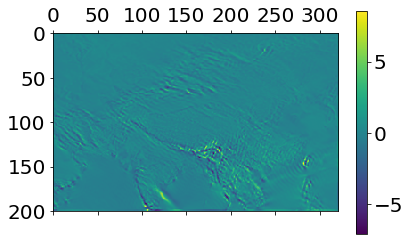

In [501]:
plt.matshow((mfc))
plt.colorbar()

## Departures from monthly means 

In [314]:
import glob 
files = glob.glob('cache/1979/era5-1979-quv-??-hour??.nc')
temp_files = glob.glob('cache/1979/era5-1979-??-hour??.nc')

temp_files.sort()
files.sort()

quvec = np.zeros(q.shape)
qvvec = np.zeros(q.shape)

# get mean data 
f = 'cache/era5_1979_may.nc'
# get variables for monthly means 
flds = xr.open_dataset(f)
u_mean = flds.u[0].values
v_mean = flds.v[0].values
q_mean = flds.q[0].values  
z_mean = flds.z[0].values
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*temp[plev])
    q_mean[plev] *= p_d
    
######hourly#########
    
for i, f in enumerate(files):
    # one hour file at the time 
    data= xr.open_dataset(f)
    tempfield = xr.open_dataset(temp_files[i])
    
    t = tempfield.t[0].values
    u = data.u.values[0]
    v= data.v.values[0]
    q= data.q.values[0]
        
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *= p_d
        
    # calculate deviations 
    u_prime = u - u_mean
    v_prime = v - v_mean
    q_prime = q - q_mean

    #  calculate product of primes 
    uq = u_prime*q_prime 
    vq = v_prime*q_prime 
        
    # monthly mean 
    qu = q_mean*u_mean
    qv = q_mean*v_mean

    # save monthly mean deviation from mean 
    quvec += (qu + uq)
    qvvec += (qv + vq)
    
    data.close()

In [315]:
# save as xarray 
xr.DataArray(quvec/744).to_netcdf('cache/qu-primes_1979_05.nc')
xr.DataArray(qvvec/744).to_netcdf('cache/qv-primes_1979_05.nc')

In [416]:
# set geopotential to 0, where surface pressure < 1000 hpa 

# effect of surface pressure
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
d = xr.open_dataset(f)
sp = d.sp[0].values/100 

coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1     
    # set q value below ground to 0 
    quvec[idx:36, ilat, ilon] = 0
    qvvec[idx:36, ilat, ilon] = 0
    
# column integration    
qu_integrated = column_integration(np.flip(quvec/744, axis= 0), np.flip(z, axis = 0), ax = 0)    
qv_integrated = column_integration(np.flip(qvvec/744, axis= 0), np.flip(z, axis = 0), ax = 0)    
    
# divergence calculation 
udev = dy_dlon(qu_integrated, dlon) 
vdev = dy_dlat(qv_integrated, dlat) 
udiv = np.hstack([udev, np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])
# sum derivatives along x and y axis to get divergence 
mfd = (udiv + vdiv)
mfc = mfd*86400*c

In [506]:
files = glob.glob('tmpdir/*geopotential*.nc')
for i in np.arange(len(files)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

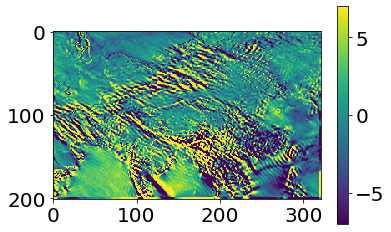

In [421]:
plt.imshow(mfd*86400,  vmin = -7, vmax = 7)
plt.colorbar()

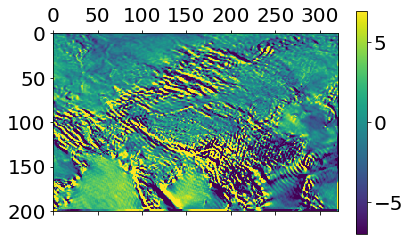

In [430]:
plt.matshow(mfd2*86400, vmin = -7, vmax = 7)
plt.colorbar()

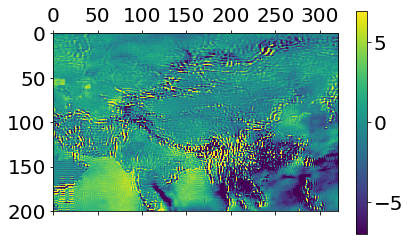

In [429]:
plt.matshow(flux_div*86400,  vmin = -7, vmax = 7)
plt.colorbar()

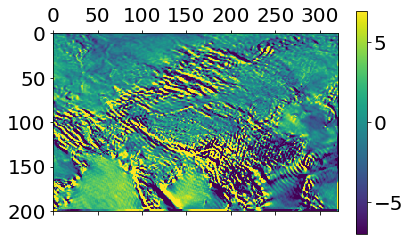

In [419]:
plt.matshow((div_accum/744)*86400, vmin = -7, vmax = 7)
plt.colorbar()

In [28]:
# get hourly surface pressure data 
hourly_sp = 'cache/era5_single-levels_1979_months5_surface_pressure_60,50,10,130.nc'
spdata = xr.open_dataset(hourly_sp)['sp'].values / 100

In [79]:
# initiate array for divergences 
div_accum = np.zeros((201,321))

for time in np.arange(744):
    if time % 50 == 0:
        print(time)
    q= qdata[time,:,:,:]
    u= udata[time, :, :, :]
    v = vdata[time, :, :, :]
    z= zdata[time, :, :, :]
    sp = spdata[time, :, :]
    t = th[time, :, :, :]
    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)
    
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
    
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *= p_d
    
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_accum += (udiv + vdiv)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


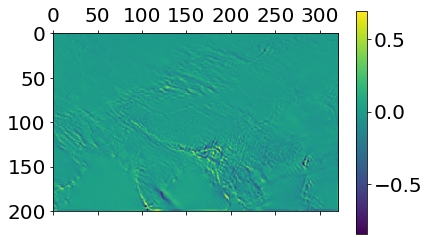

In [354]:
plt.matshow(div_accum/744*864)
plt.colorbar()

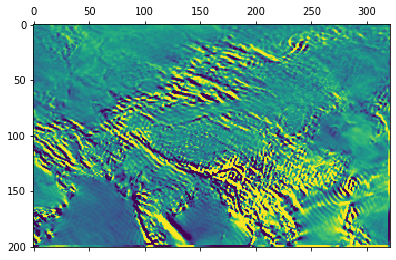

In [81]:
plt.matshow(-(div_accum/744)*86400, vmin = -10, vmax = 10)

In [3135]:
# initiate array for divergences without Z correction 
div_noZ = np.zeros((201,321))

for t in np.arange(744):
    q= qdata[t,:,:,:]
    u= udata[t, :, :, :]
    v = vdata[t, :, :, :]
    z= zdata[t, :, :, :]
    sp = spdata[t, :, :]
    
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_noZ += (udiv + vdiv)


In [ ]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*th[plev])
    m = q[plev] *p_d
    q[plev] = m 
        

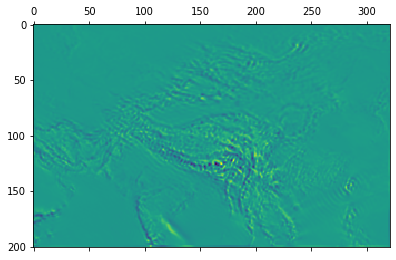

In [3163]:
# accumulated divergence field 
plt.matshow(div_accum)

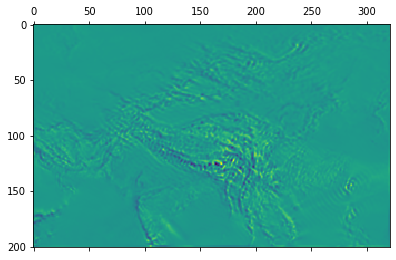

In [3164]:
plt.matshow(div)

In [167]:
diva = (div_accum /744) * 86400 


In [170]:
diva.max()

69.50637220995186

In [3225]:
divm.mean()

3.0535584230642054e-06

## Plot water balance 

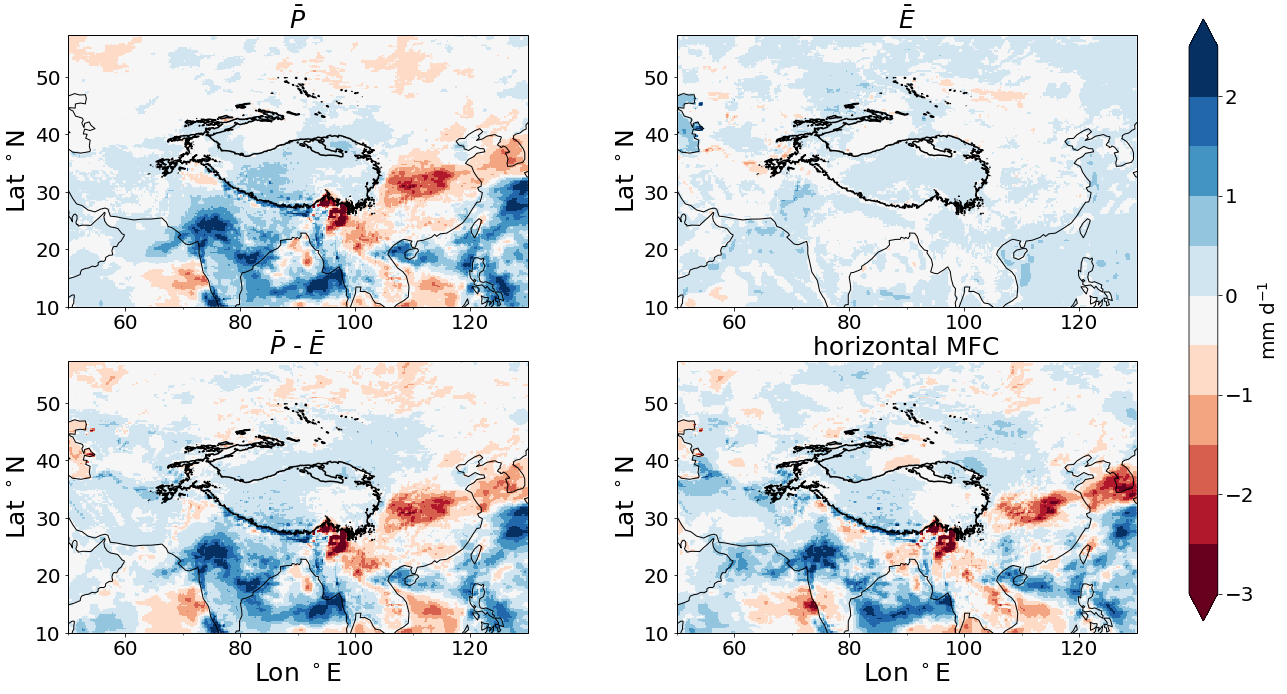

In [62]:
fig =plt.figure(figsize=(20,11))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
#cmap=plt.cm.Spectral
r = np.arange(-3,3,0.5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values

# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P - P1979,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E - E1979, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e - (P1979-E1979) , norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$ ', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -vimd + vimd1979, cmap = cmap ,norm = norm )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('horizontal MFC', fontsize= fs)
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels) 
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm d$^{-1}$')
plt.rcParams.update({'font.size': 20})

plt.savefig('plots/moisture_budget_change_first_last_decades.png')
plt.show()

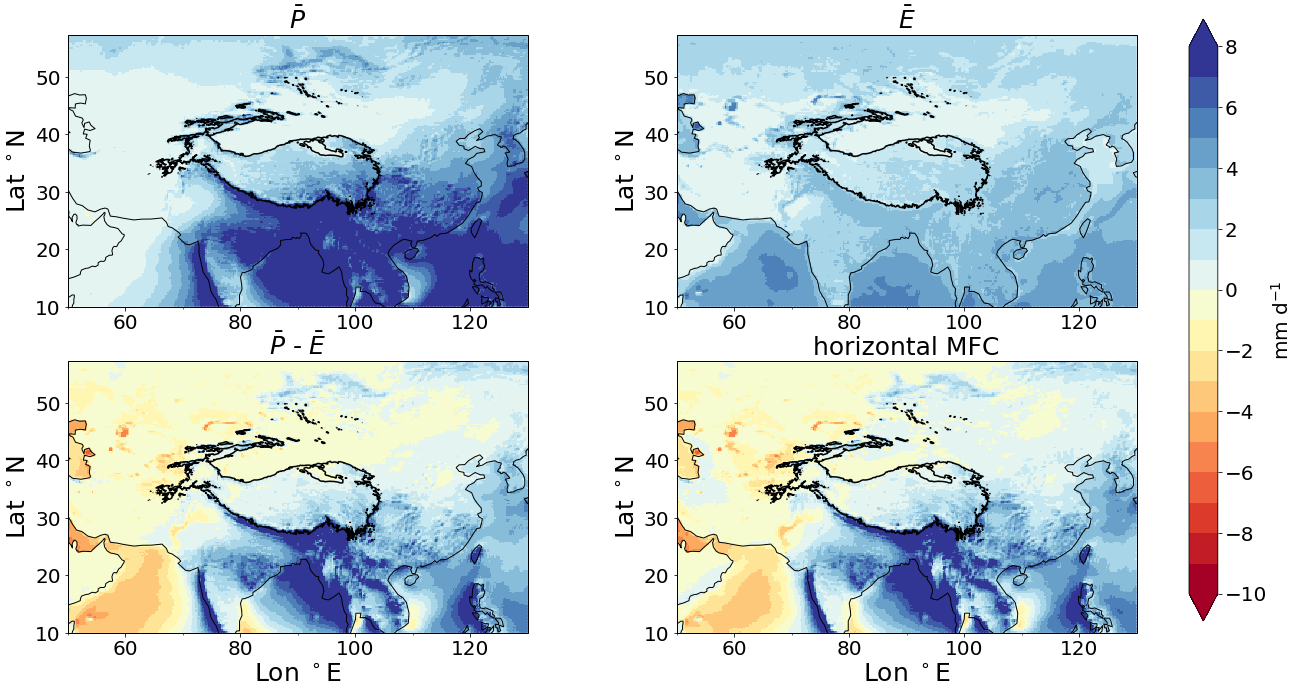

In [47]:
fig =plt.figure(figsize=(20,11))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdYlBu
#cmap=plt.cm.Spectral
r = np.arange(-10,9)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values

# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'$\bar P$', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title(r'$\bar E$', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title(r'$\bar P$ - $\bar E$ ', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)



# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -vimd, cmap = cmap ,norm = norm )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('horizontal MFC', fontsize= fs)
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels) 
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm d$^{-1}$')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/moisture_budget_2000-2019.png')
plt.show()

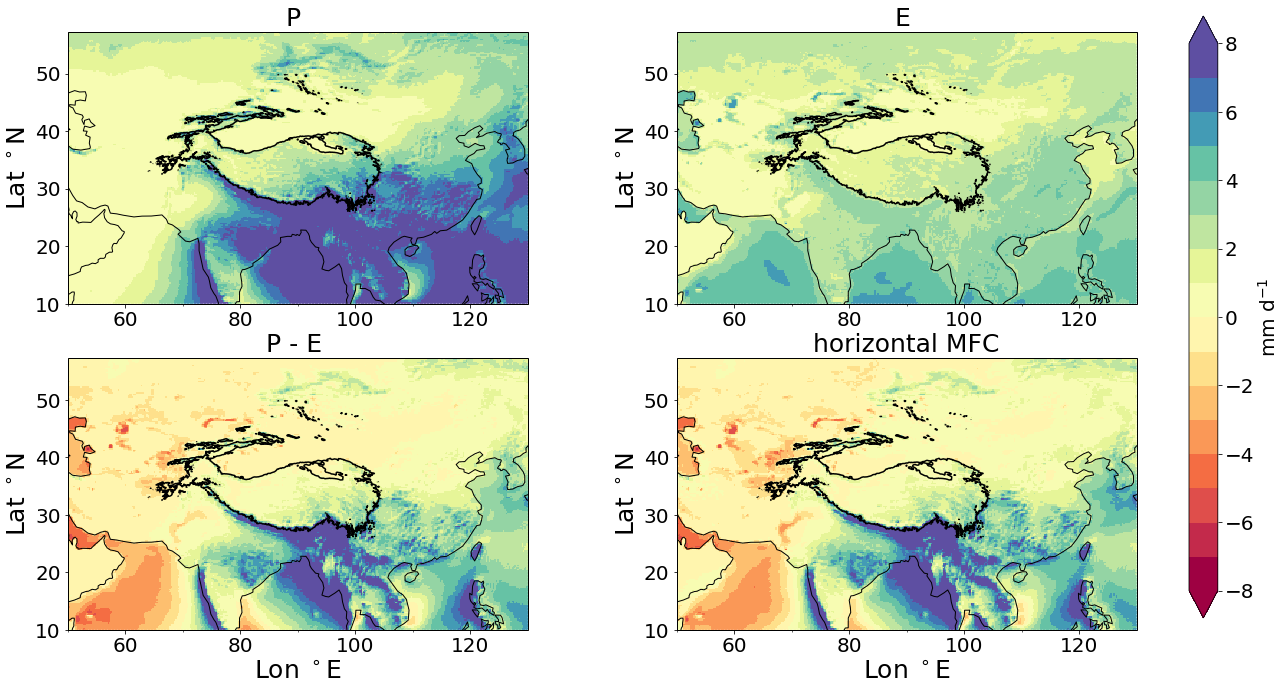

In [614]:
fig =plt.figure(figsize=(20,11))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
cmap=plt.cm.Spectral
r = np.arange(-8,9)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values

# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title('P ', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title('E ', fontsize= fs)
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title('P - E ', fontsize = fs)
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)



# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -vimd, cmap = cmap ,norm = norm )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('horizontal MFC', fontsize= fs)
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm d$^{-1}$')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/P_E_moisture_budget.png')
plt.show()

## Convective vs. large-scale precipitation 

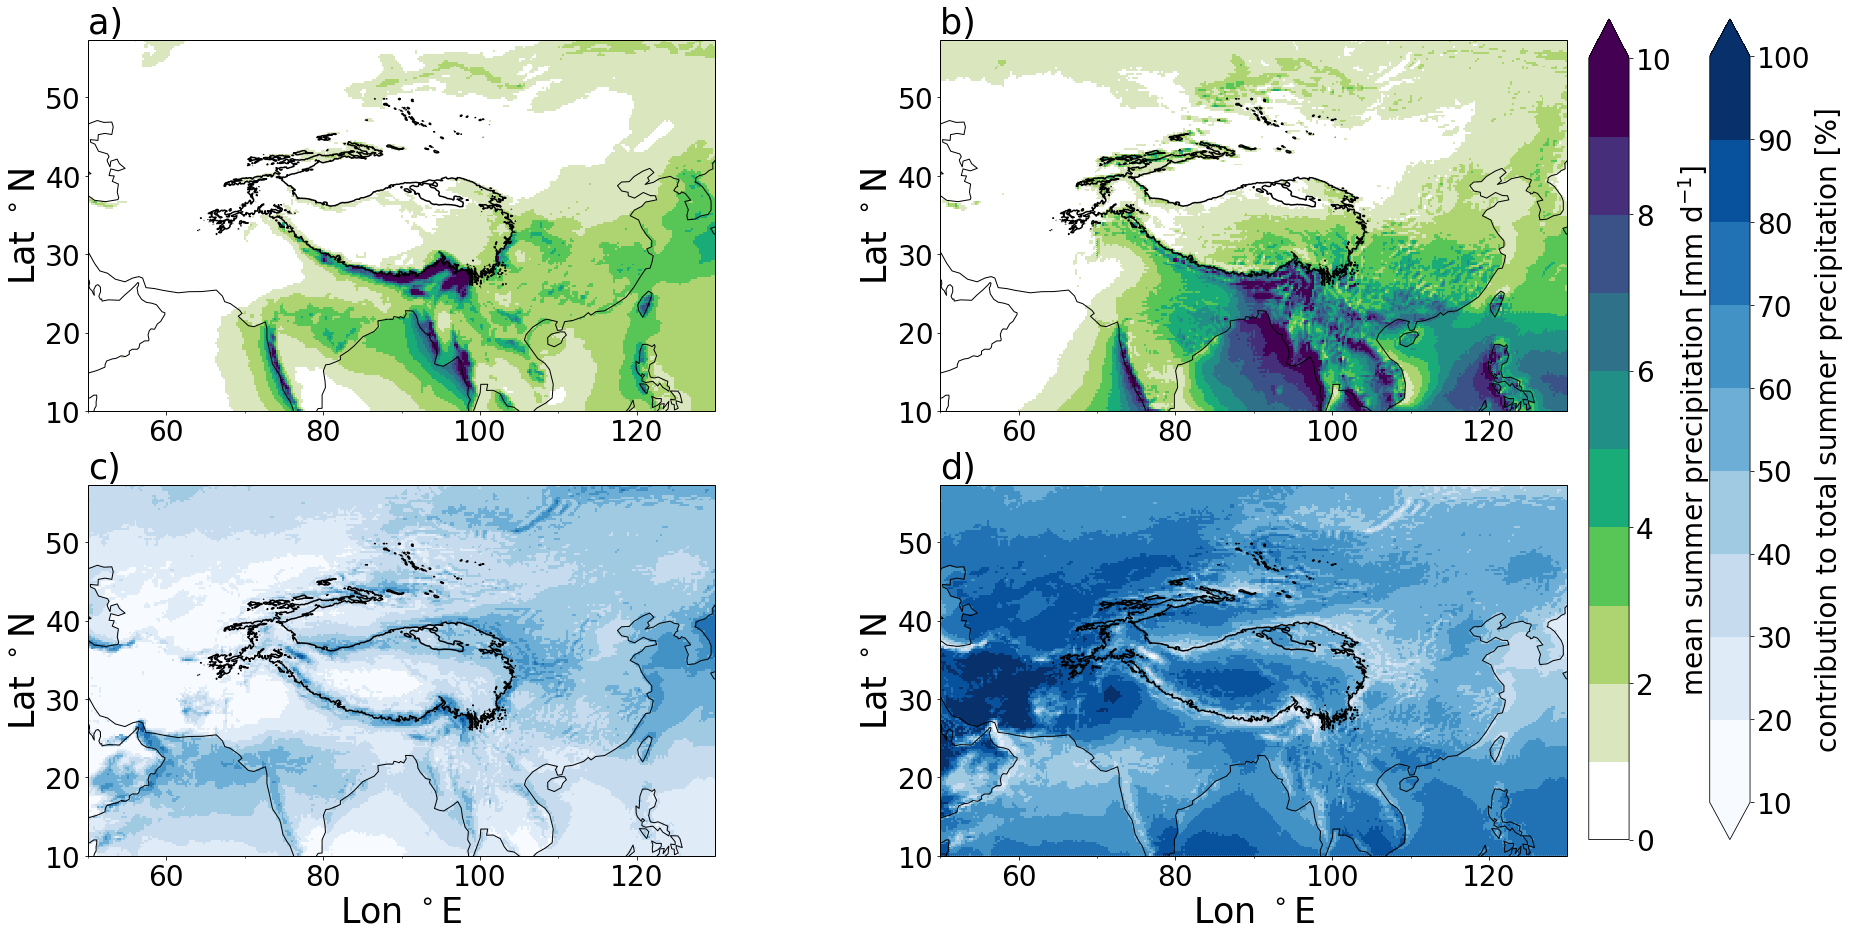

In [13]:
from obspy.imaging.cm import viridis_white_r

fig =plt.figure(figsize=(28,15))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 35

# customizing of colorbar 
cmap=viridis_white_r
cmap2= plt.cm.Blues

r = np.arange(11)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
r = np.arange(10,110,10)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

lons = precip.longitude.values
lats = precip.latitude.values

ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats,lsp,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title('a)  ', fontsize= fs, loc= 'left')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax2.pcolormesh(lons, lats, cp, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title('b) ',fontsize= fs,loc= 'left')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m2= ax3.pcolormesh(lons, lats, lsp/P * 100 , norm = norm2, cmap = cmap2  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title('c)',fontsize= fs,loc= 'left')
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=fs)


ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m2 = ax4.pcolormesh(lons, lats, cp/P * 100 , norm = norm2, cmap = cmap2  )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('d)',fontsize= fs,loc= 'left')
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)


cb_ax1 = fig.add_axes([0.89, 0.14,0.02, 0.76])
cb_ax2 = fig.add_axes([0.95, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'max', label = 'mean summer precipitation [mm d$^{-1}$]')
cbar = fig.colorbar(m2, cax=cb_ax2, extend = 'both', label = 'contribution to total summer precipitation [%]')

plt.rcParams.update({'font.size': 28})


plt.savefig('plots/ERA5_convect_precip.png', bbox_inches= 'tight')
plt.show()


In [220]:
supersmooth = -(moisture_field/41)*86400*C

In [378]:
smoothed = wrf.smooth2d(mdiv_calculated, passes = 2)

## Time series of P, E and moisture transport 

Is summer precipitation variability dominated by moisture transport (remote controls) or by evaporation anomalies (local controls)? --> clearly moisture transport! 

In [2]:
f= 'cache/timeseries/precip_timeseries.nc'
p = xr.open_dataset(f)
P = p.tp.values[:,0,0]*1000
f= 'cache/timeseries/evapo_timeseries.nc'
e = xr.open_dataset(f)
E = e.e.values[:,0,0]*-1000
f= 'cache/timeseries/moistdiv_timeseries.nc'
m = xr.open_dataset(f)
moistdiv = m['vimd'].values[:,0,0]

time = np.arange(1979,2020)

NameError: name 'xr' is not defined

In [405]:
# timeseries as area 

f= 'cache/srfc-monthly/prcp_annual_means.nc'
p = xr.open_dataset(f)
prcp = p.tp[:,1:,:]*1000
f= 'cache/srfc-monthly/evapo_annual_means.nc'
e = xr.open_dataset(f)
evapo = e.e[:,1:,:]*-1000
f= 'cache/srfc-monthly/moistdiv_annual_means.nc'
m = xr.open_dataset(f)
mfd = m['vimd'][:,1:,:] 

time = np.arange(1979,2020)

In [619]:
# timeseries as area 

f= 'cache/srfc-monthly/prcp_anomalies.nc'
p = xr.open_dataset(f)
prcp = p.tp[:,:-1,:-1]*1000
f= 'cache/srfc-monthly/evapo_anomalies.nc'
e = xr.open_dataset(f)
evapo = e.e[:,:-1,:-1]*-1000
f= 'cache/srfc-monthly/moistdiv_anomalies.nc'
m = xr.open_dataset(f)
mfd = m['vimd'][:,:-1,:-1] 

time = np.arange(1979,2020)

m.close()
p.close()
e.close()

In [508]:
# apply land sea mask 
lm= xr.open_dataset('lsm_era5_tp.nc')['lsm'][0]
lsm= np.flip(lm, axis = 0)

In [509]:
# apply land mask 
mfd.values[:, lsm == 0] = np.nan
prcp.values[:, lsm== 0 ] = np.nan
evapo.values[:, lsm == 0] = np.nan


In [595]:
# apply Himalaya mask 

mfd = mfd[:,100:140,80:210]
prcp= prcp[:,100:140,80:210]
evapo = evapo[:,100:140,80:210]

In [406]:
# apply elevation mask 

mfd.values[:,elevs < 3000 ] = np.nan
prcp.values[:,elevs < 3000 ] = np.nan
evapo.values[:,elevs < 3000 ] = np.nan

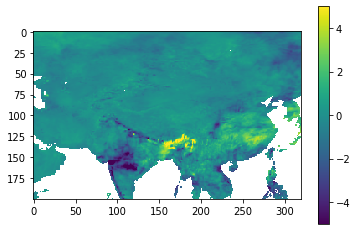

In [67]:
plt.imshow(mfd[34], vmin = -5, vmax = 5)
plt.colorbar()

In [441]:
# calculate weightes mean Himalaya
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'time':data.time.values,'latitude':data.latitude[100:140].values, 'longitude':data.longitude[80:210].values})
    weights = np.cos(np.deg2rad(data.latitude[100:140]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean.values, data_weighted, weights

In [620]:
# calculate weightes mean area
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'time':data.latitude[:-1].values,'latitude':data.latitude[:-1].values, 'longitude':data.longitude[:-1].values})
    weights = np.cos(np.deg2rad(data.latitude[:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean.values, data_weighted, weights

In [607]:
# calculate weightes 
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'latitude':data.latitude[:-1].values, 'longitude':data.longitude[:-1].values})
    weights = np.cos(np.deg2rad(data.latitude[:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean.values, data_weighted, weights

In [621]:
# timeseries 
moistdiv= weighted_mean(mfd.values)[0]
P = weighted_mean(prcp.values)[0]
E = weighted_mean(evapo.values)[0]

In [510]:
# timeseries 
moistdiv_land = weighted_mean(mfd.values)[0]
P_land = weighted_mean(prcp.values)[0]
E_land = weighted_mean(evapo.values)[0]

In [407]:
# timeseries 
moistdiv_tp = weighted_mean(mfd.values)[0]
P_tp = weighted_mean(prcp.values)[0]
E_tp = weighted_mean(evapo.values)[0]

## Precipitation recycling 

Estimate of the contribution of evaporation to the precipitable water and precipitation budget within a region on a climatological scale


**What is the contribution of precipitation of local (evaporative) origin?** 


In [408]:
lcr = E/ (E-moistdiv)
lcr_land = E_land / (E_land -moistdiv_land)
lcr_tp = E_tp / (E_tp - moistdiv_tp)

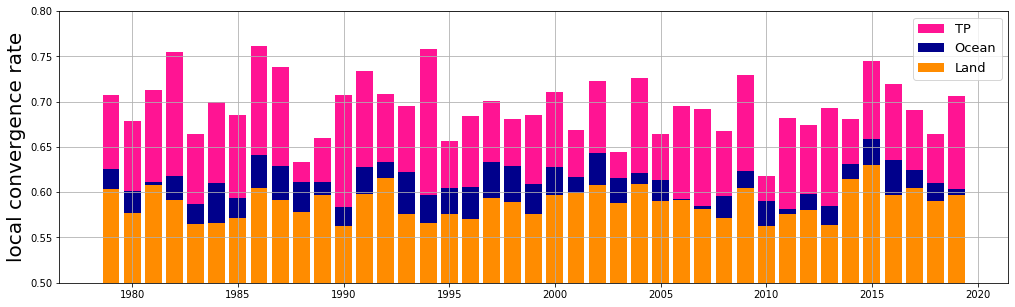

In [409]:
plt.figure(figsize= (17,5))
s= 20 

plt.bar( time, lcr_tp  , label = 'TP', color = 'deeppink', linewidth = 2.0)
plt.bar( time, lcr, label = 'Ocean', color = 'darkblue', linewidth = 2.0)
plt.bar( time, lcr_land , label = 'Land', color = 'darkorange', linewidth = 2.0)

plt.ylim(0.5, 0.8)
plt.ylabel('local convergence rate', fontsize = s)
plt.legend(fontsize= 13)
plt.grid()

plt.savefig('plots/local_convergence_rate.png')
plt.show()

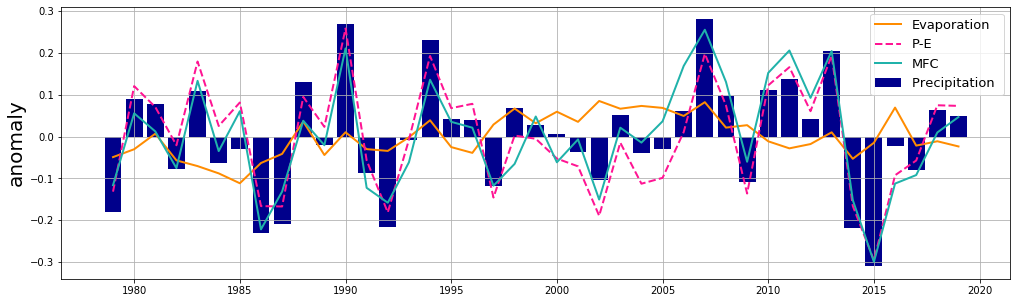

In [522]:
plt.figure(figsize= (17,5))
s= 20

plt.bar( time, P - np.nanmean(P), label = 'Precipitation ', color = 'darkblue', linewidth = 2.0)
plt.plot(time, E - np.nanmean(E), label = 'Evaporation', color = 'darkorange', linewidth = 2.0)
plt.plot(time, (P-E) - np.nanmean(P- E), label = 'P-E', color ='deeppink', linestyle = '--',linewidth = 2.0)
plt.plot(time, -(moistdiv) - np.nanmean(-moistdiv), label = 'MFC', color = 'lightseagreen', linewidth= 2.0)
plt.ylabel('anomaly', fontsize = s)
plt.legend(fontsize= 13)
plt.grid()

plt.savefig('plots/timeseries_p_e_mfc_domain.png')
plt.show()

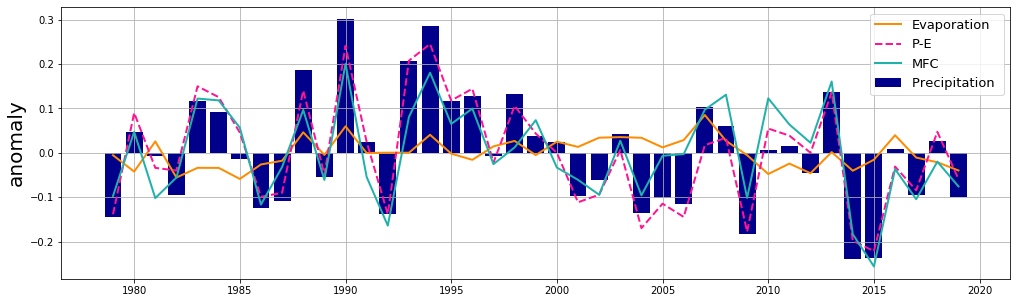

In [570]:
plt.figure(figsize= (17,5))
s= 20

plt.bar( time, P , label = 'Precipitation ', color = 'darkblue', linewidth = 2.0)
plt.plot(time, E , label = 'Evaporation', color = 'darkorange', linewidth = 2.0)
plt.plot(time, (P-E) , label = 'P-E', color ='deeppink', linestyle = '--',linewidth = 2.0)
plt.plot(time, -(moistdiv) , label = 'MFC', color = 'lightseagreen', linewidth= 2.0)
plt.ylabel('anomaly', fontsize = s)
plt.legend(fontsize= 13)
plt.grid()

plt.savefig('plots/timeseries_p_e_mfc_land.png')
plt.show()

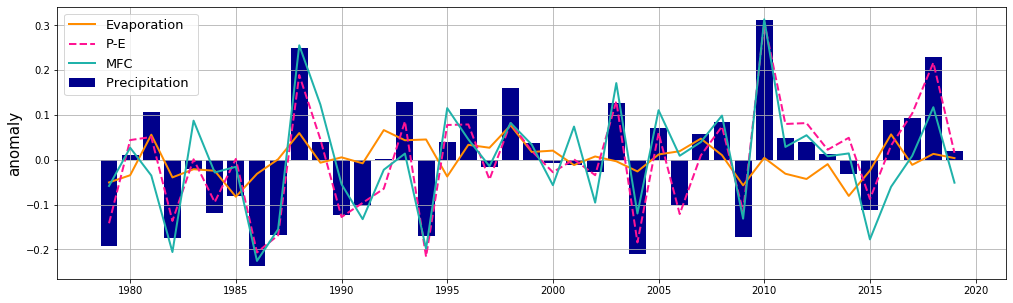

In [617]:
plt.figure(figsize= (17,5))
s= 15

plt.bar( time, P, label = 'Precipitation ', color = 'darkblue', linewidth = 2.0)
plt.plot(time, E , label = 'Evaporation', color = 'darkorange', linewidth = 2.0)
plt.plot(time, (P-E ) , label = 'P-E', color ='deeppink', linestyle = '--',linewidth = 2.0)
plt.plot(time, -(moistdiv), label = 'MFC', color = 'lightseagreen', linewidth= 2.0)
plt.ylabel('anomaly', fontsize = s)
plt.legend(fontsize= 13)
plt.grid()


plt.savefig('plots/timeseries_p_e_mfc_tp.png')
plt.show()

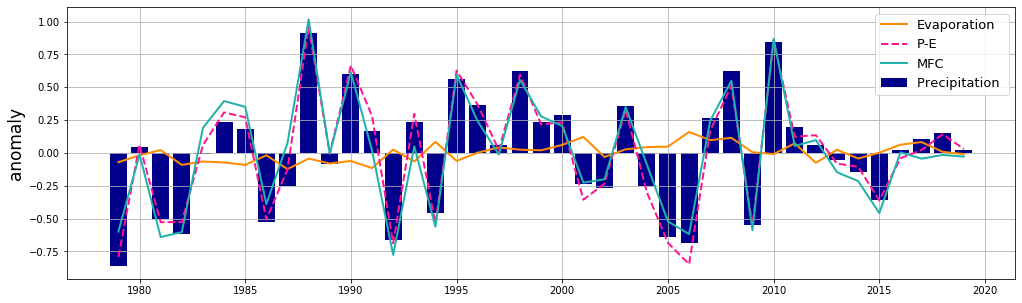

In [601]:
plt.figure(figsize= (17,5))
s= 17

plt.bar( time, P , label = 'Precipitation ', color = 'darkblue', linewidth = 2.0)
plt.plot(time, E  , label = 'Evaporation', color = 'darkorange', linewidth = 2.0)
plt.plot(time, (P- E) , label = 'P-E', color ='deeppink', linestyle = '--',linewidth = 2.0)
plt.plot(time, -moistdiv , label = 'MFC', color = 'lightseagreen', linewidth= 2.0)
plt.ylabel('anomaly', fontsize = s)
plt.legend(fontsize= 13)
plt.grid()

plt.savefig('plots/timeseries_p_e_mfc_himalayareg.png')
plt.show()

## Variability and thermodynamic vs. dynamic changes 

In [585]:
def wrf_derivative_v(qvint):
    qvint_padded = qvint[:-1, :-1]
    f_qvint = np.fft.fft(qvint_padded, axis=0)

    m, n = f_qvint.shape
    m2 = m // 2
    n2 = n // 2

    f_lat = 2.0 * np.pi * np.fft.fftfreq(m, d= 9000 ) 
    f_lat[m2] = 0.0
    f_lat = np.broadcast_to(f_lat.reshape(-1, 1), (m, n))  
    
    df_qvint_dy = f_qvint.copy() * -1j * f_lat
    
    d_m = 60
    df_qvint_dy[m2 - d_m : m2 + d_m + 1, :] *= 0.0
    
    return np.fft.ifft(df_qvint_dy, axis = 0).real


In [584]:
def wrf_derivative_u(quint):
    quint_padded = quint[:-1, :-1]
    f_quint = np.fft.fft(quint_padded, axis=1)

    m, n = f_quint.shape
    m2 = m // 2
    n2 = n // 2
    f_lon= f_quint.copy()
    
    f_lon = 2.0 * np.pi * np.fft.fftfreq(n, d= 9000)
    f_lon[n2] = 0.0
    
    f_lon = np.broadcast_to(f_lon.reshape(1, -1), (m, n)) 
    df_quint_dx = f_quint.copy() * 1j * f_lon 
    
    #d_n = 50
    #df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0
    
    return np.fft.ifft(df_quint_dx, axis = 1).real

In [1]:
def derivative_v(qvint):
    qvint_padded = np.vstack([np.flipud(qvint[:-1, :-1]), qvint[:-1, :-1], np.flipud(qvint[:-1, :-1])]) 
    f_qvint = np.fft.fft(qvint_padded, axis=0)

    m, n = f_qvint.shape
    m2 = m // 2
    n2 = n // 2

    f_lat = 2.0 * np.pi * np.fft.fftfreq(m, d= dlat[0,0]/2) 
    f_lat[m2] = 0.0
    f_lat = np.broadcast_to(f_lat.reshape(-1, 1), (m, n))  
    
    df_qvint_dy = f_qvint.copy() * -1j * f_lat
    
    #d_m = 60
    #df_qvint_dy[m2 - d_m : m2 + d_m + 1, :] *= 0.0
    
    return np.fft.ifft(df_qvint_dy, axis = 0).real


In [2]:
def derivative_u(quint):
    quint_padded = np.hstack([np.fliplr(quint[:-1, :-1]), quint[:-1, :-1], np.fliplr(quint[:-1, :-1])]) 
    f_quint = np.fft.fft(quint_padded, axis=1)

    m, n = f_quint.shape
    m2 = m // 2
    n2 = n // 2
    f_lon= f_quint.copy()
    
    f_lon = 2.0 * np.pi * np.fft.fftfreq(n, d= dlon[:-1,[0]]/2)
    f_lon[:,n2] = 0.0
    
    #f_lon = np.broadcast_to(f_lon.reshape(1, -1), (m, n)) 
    df_quint_dx = f_quint.copy() * 1j * f_lon 
    
    #d_n = 50
    #df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0
    
    return np.fft.ifft(df_quint_dx, axis = 1).real

In [605]:
import glob 

### ERA5 
f= 'cache/pressure-monthly/era5-pressure-levels-monthly-climatology.nc'
anomalies = glob.glob('cache/pressure-monthly/*anomaly*.nc')
sp_files= glob.glob('cache/srfc-monthly/srfc_pressure_????.nc')
files= glob.glob('cache/pressure-monthly/era5_pressure-levels-monthly_????.nc')
temp_files= glob.glob('cache/pressure-monthly/tempmean_????.nc')

temp_files.sort()
sp_files.sort()
files.sort()
anomalies.sort()
data = xr.open_dataset(f)
pressure = data.level.values
dlat,dlon = atm.get_spacing(data.latitude.values, data.longitude.values)

In [608]:
thermodynamic= np.array(())
dynamic = np.array(())
thermodynamic_land= np.array(())
dynamic_land = np.array(())

# read in files for each year 
for y in np.arange(41):
    
    # clim values 
    q_c= data.q[0].values
    u_c = data.u[0].values
    v_c= data.v[0].values
    
    print(y)
    ds = xr.open_dataset(anomalies[y])
    sp = xr.open_dataset(sp_files[y]).sp[0].values / 100
    t = xr.open_dataset(temp_files[y]).t[0]
    z = xr.open_dataset(files[y]).z[0].values #,:,:-1, :-1
    q_a= ds.q[0]
    u_a= ds.u[0]
    v_a= ds.v[0]

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q_a[idx:36, ilat, ilon] = 0
        q_c[idx:36, ilat, ilon] = 0

    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q_a[plev] *=  p_d  
        q_c[plev] *=  p_d 
        
    # product for thermodynamic and dynamic component 
    qc_ua = q_c* u_a 
    qc_va = q_c* v_a
        
    qa_uc = q_a*u_c
    qa_vc = q_a*v_c
        
    # column-integration   
    dyna_quint = atm.column_integration(np.flip(qc_ua, axis = 0), np.flip(z, axis = 0), ax = 0)
    dyna_qvint = atm.column_integration(np.flip(qc_va, axis = 0), np.flip(z, axis = 0), ax = 0)
 
    thermo_quint = atm.column_integration(np.flip(qa_uc, axis = 0), np.flip(z, axis = 0), ax = 0)
    thermo_qvint = atm.column_integration(np.flip(qa_vc, axis = 0), np.flip(z, axis = 0), ax = 0)

    # calculate divergences
    thermo_udiff = derivative_u(thermo_quint)[:,320:320*2]
    thermo_vdiff = derivative_v(thermo_qvint)[200:400, :]

    dyna_udiff = derivative_u(dyna_quint)[:,320:320*2] 
    dyna_vdiff = derivative_v(dyna_qvint)[200:400, :]

    # unit and build sum to create divergence from derivatives 
    thermo_div = -(thermo_udiff   + thermo_vdiff) * 86400 
    dyna_div = -(dyna_udiff  + dyna_vdiff) * 86400

    # calculate regional average and append to timeseries 
    th = weighted_mean(thermo_div)[0]
    dy =  weighted_mean(dyna_div)[0]   

    thermodynamic = np.append(thermodynamic,th)
    dynamic = np.append(dynamic,dy)
    
    #apply land mask 
    thermo_div[lsm== 0] = np.nan
    dyna_div[lsm == 0] = np.nan
    th_land = weighted_mean(thermo_div)[0] 
    dy_land =  weighted_mean(dyna_div)[0]      
    
    thermodynamic_land = np.append(thermodynamic_land,th_land)
    dynamic_land = np.append(dynamic_land,dy_land)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


## Thermodynamic vs. dynamic contributions in WRF 9km simulation 

In [567]:
### WRF 
f= 'wrftp/data/monthly/awt_clim.nc'
anomalies = glob.glob('wrftp/data/monthly/*anomaly*.nc')
files= glob.glob('wrftp/data/monthly/wrfout_TP9km_????.nc')
files.sort()
anomalies.sort()
climdata = xr.open_dataset(f)

import warnings
warnings.filterwarnings('ignore')


In [568]:
def column_integration(values, z, ax = None ):
    if ax == None:
        ax = 0
    # integration of column values without z conversion 
    colint = np.trapz(values,z, axis =ax )
    return colint

In [599]:
thermodynamic= np.array(())
dynamic = np.array(())

# read in files for each year 
for y in np.arange(18):
    # clim values 
    q_c = climdata.r_v_p[0]
    u_c = climdata.u_tr_p[0]
    v_c = climdata.v_tr_p[0]
    q_c=np.nan_to_num(q_c, 0)
    u_c= np.nan_to_num(u_c, 0)
    v_c= np.nan_to_num(v_c, 0)
    
    # read in anomalies and pressure data 
    data = xr.open_dataset(anomalies[y])
    pdata = xr.open_dataset(files[y])
    
    q_a = data.r_v_p[0].values
    u_a = data.u_tr_p[0].values
    v_a = data.v_tr_p[0].values
    z = pdata.Z_p[0].values
    t = pdata.T_p[0].values
    
    q_a=np.nan_to_num(q_a, 0)
    u_a= np.nan_to_num(u_a, 0)
    v_a= np.nan_to_num(v_a, 0)
    z=np.nan_to_num(z, 0)
    #t= np.nan_to_num(t, 0)
    
    pressure = data.pressure.values
    lons = data.lon.values
    lats = data.lat.values
    data.close()

    # convert specific humidity to absolute humidity in kg/m3                                                                                          
    for plev in np.arange(29):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q_a[plev] =q_a[plev]* p_d
        q_c[plev] =q_c[plev]* p_d

    # products for thermodynamic and dynamic component 
        
    q_a=np.nan_to_num(q_a, 0)
    q_c=np.nan_to_num(q_c, 0)
    
    qc_ua = q_c*u_a 
    qc_va = q_c*v_a
    qa_uc = q_a*u_c
    qa_vc = q_a*v_c
    
    # column-integration   
    dyna_quint = column_integration(qc_ua, z, ax = 0)
    dyna_qvint = column_integration(qc_va, z,  ax = 0)
 
    thermo_quint = column_integration(qa_uc,z, ax = 0)
    thermo_qvint = column_integration(qa_vc,z, ax = 0)

    # calculate divergences
    thermo_udiff = wrf_derivative_u(thermo_quint)
    thermo_vdiff = wrf_derivative_v(thermo_qvint)

    dyna_udiff = wrf_derivative_u(dyna_quint)
    dyna_vdiff = wrf_derivative_v(dyna_qvint)

    # unit and build sum to create divergence from derivatives 
    thermo_div = -(thermo_udiff   + thermo_vdiff) 
    dyna_div = -(dyna_udiff  + dyna_vdiff) 

    # calculate regional average and append to timeseries
    m= np.nanmean(thermo_div, axis =0)
    th = np.nanmean(m, axis =0)
    m= np.nanmean(dyna_div, axis =0)
    dy =  np.nanmean(m, axis =0) 

    thermodynamic = np.append(thermodynamic,th)
    dynamic = np.append(dynamic,dy)


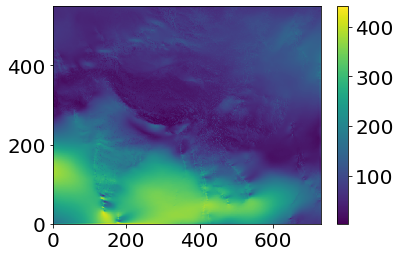

In [600]:
plt.pcolormesh(dyna_quint)
plt.colorbar()

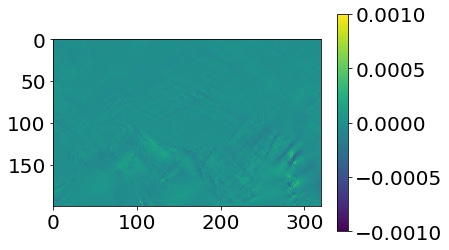

In [610]:
plt.imshow(dyna_udiff, vmin = -0.001, vmax = 0.001)
plt.colorbar()

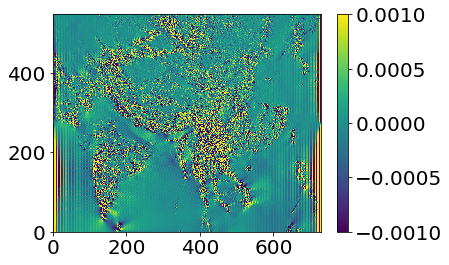

In [603]:
plt.pcolormesh(dyna_udiff, vmin = -0.001, vmax = 0.001)
plt.colorbar()

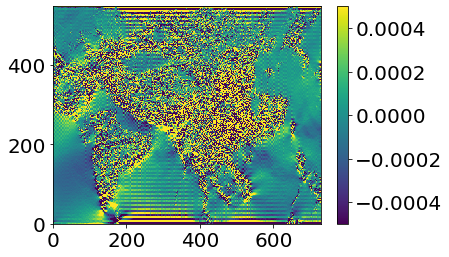

In [591]:
plt.pcolormesh(dyna_vdiff, vmin =-0.0005, vmax = 0.0005)
plt.colorbar()

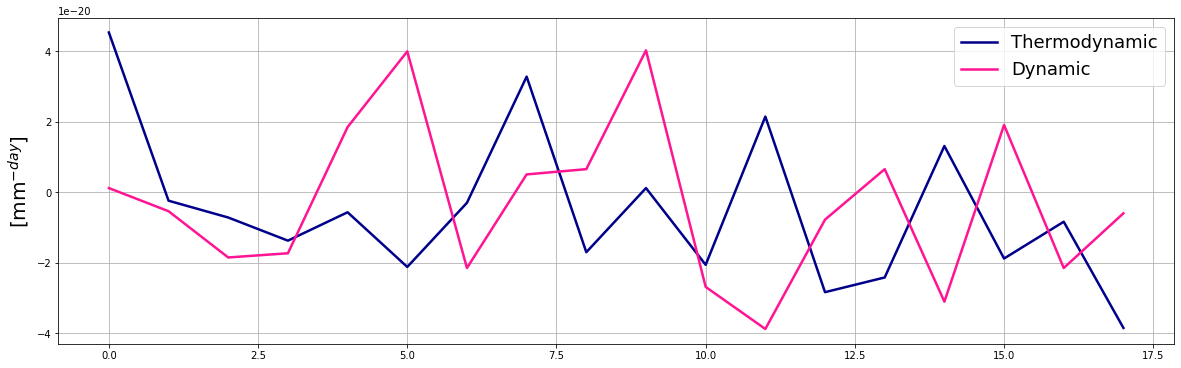

In [461]:
plt.figure(figsize= (20,6))
s= 20

plt.plot(np.arange(18), thermodynamic, label = 'Thermodynamic', color = 'darkblue', linewidth = 2.5)
plt.plot(np.arange(18), dynamic, label = 'Dynamic', color ='deeppink',linewidth = 2.5)

plt.ylabel('[mm$^{-day}$]', fontsize = s)
plt.legend(fontsize= 18)
plt.grid()

plt.savefig('plots/wrf_timeseries_thermodynamic_dynamic_variability.png')
plt.show()

In [46]:
dlat,dlon = get_spacing(lats,lons)

In [45]:
def get_spacing(latitudes,longitudes):
    # convert lats and lons to cartesian coordinates                                                                                                           
    x = Rad * np.cos(np.radians(latitudes)) * np.cos(np.radians(longitudes))
    y = Rad * np.cos(np.radians(latitudes)) * np.sin(np.radians(longitudes))
    z = Rad *np.sin(np.radians(latitudes))

    # stack to get 3D array                                                                                                                                    
    cartesian = np.stack([x, y, z], axis = 2)
    # pythagorean theorem to get distances in meter                                                                                                            
    dlat = np.sqrt(np.sum((cartesian[2:, :] - cartesian[:-2,:]) ** 2, axis=-1))
    dlon = np.sqrt(np.sum((cartesian[:, 2:] - cartesian[:,:-2]) ** 2, axis=-1))

    return dlat,dlon


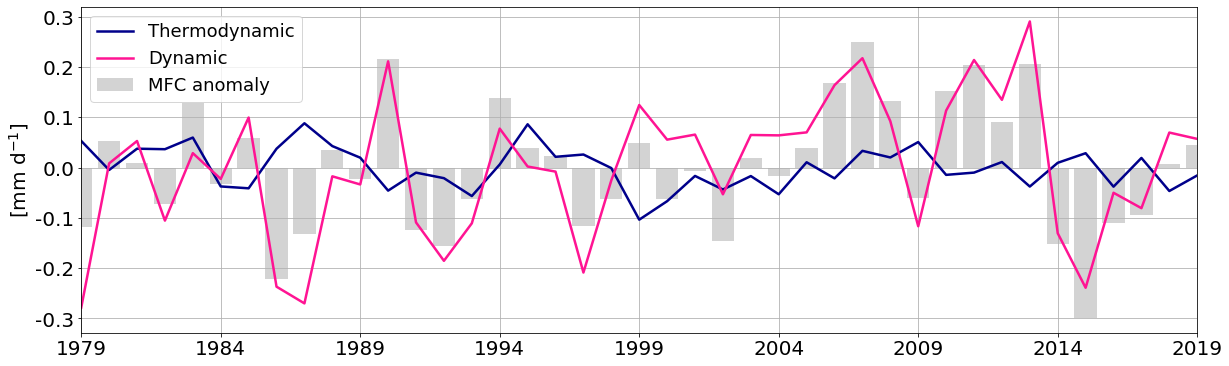

In [449]:
plt.figure(figsize= (20,6))
s= 20

plt.plot(time, thermodynamic, label = 'Thermodynamic', color = 'darkblue', linewidth = 2.5)
plt.plot(time, dynamic, label = 'Dynamic', color ='deeppink',linewidth = 2.5)
plt.bar(time, -moistdiv , label = 'MFC anomaly', color ='lightgray',linewidth = 2.0)


plt.ylabel('[mm d$^{-1}$]', fontsize = s)
plt.legend(fontsize= 18)
plt.grid()
plt.xlim(time[0], time[-1])
yticks= np.round(np.arange(-0.3,0.4, 0.1), decimals = 2)
plt.yticks(yticks, yticks,fontsize= s )
plt.xticks(time[::5], time[::5], fontsize= s)


plt.savefig('plots/timeseries_thermodynamic_dynamic_var.png')
plt.show()

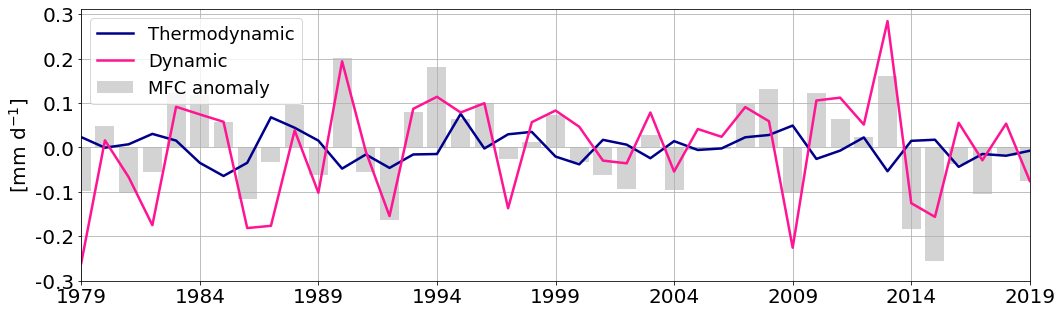

In [642]:
plt.figure(figsize= (17,5))
s= 20

plt.plot(time, thermodynamic_land, label = 'Thermodynamic', color = 'darkblue', linewidth = 2.5)
plt.plot(time, dynamic_land, label = 'Dynamic', color ='deeppink',linewidth = 2.5)
plt.bar(time, -moistdiv_land - np.nanmean(-moistdiv_land), label = 'MFC anomaly', color ='lightgray',linewidth = 2.0)


plt.ylabel('[mm d$^{-1}$]', fontsize = s)
plt.legend(fontsize= 18)
plt.grid()
plt.xlim(time[0], time[-1])
yticks= np.round(np.arange(-0.3,0.4, 0.1), decimals = 2)
plt.yticks(yticks, yticks,fontsize= s )
plt.xticks(time[::5], time[::5], fontsize= s)


plt.savefig('plots/timeseries_thermodynamic_dynamic_var_land.png')
plt.show()

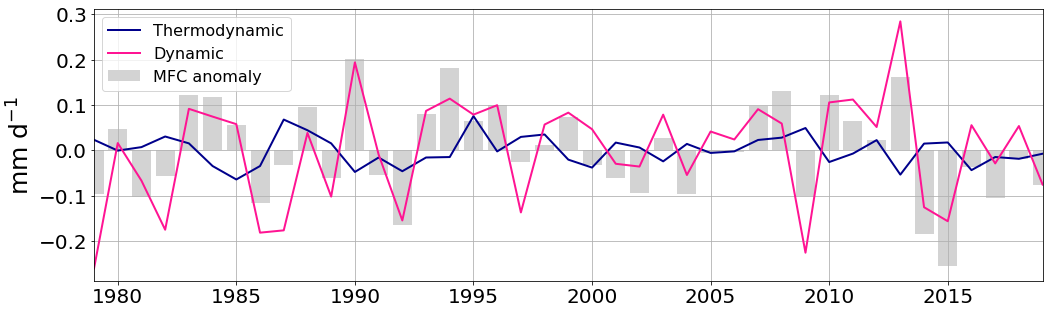

In [641]:
plt.figure(figsize= (17,5))
s= 25

plt.bar( time,-(moistdiv_land) , label = 'MFC anomaly', color = 'lightgrey', linewidth = 2.0)
plt.plot(time, thermodynamic_land, label = 'Thermodynamic', color = 'darkblue', linewidth = 2.0)
plt.plot(time, dynamic_land, label = 'Dynamic', color ='deeppink',linewidth = 2.0)


plt.ylabel('mm d$^{-1}$', fontsize = s)
plt.legend(fontsize= 16)
plt.grid()
plt.xlim(time[0], time[-1])

plt.savefig('plots/timeseries_thermodynamic_dynamic_variability_land.png')
plt.show()

In [625]:
from scipy import stats 
slope_land, intercept_land, r_value_land, p_value, std_err = stats.linregress(-moistdiv_land,dynamic_land)
slope, intercept, r_value, p_value, std_err = stats.linregress(-moistdiv,dynamic)

In [628]:
r_value**2

0.7991046962445689

In [626]:
r_value_land**2

0.6695735030273028

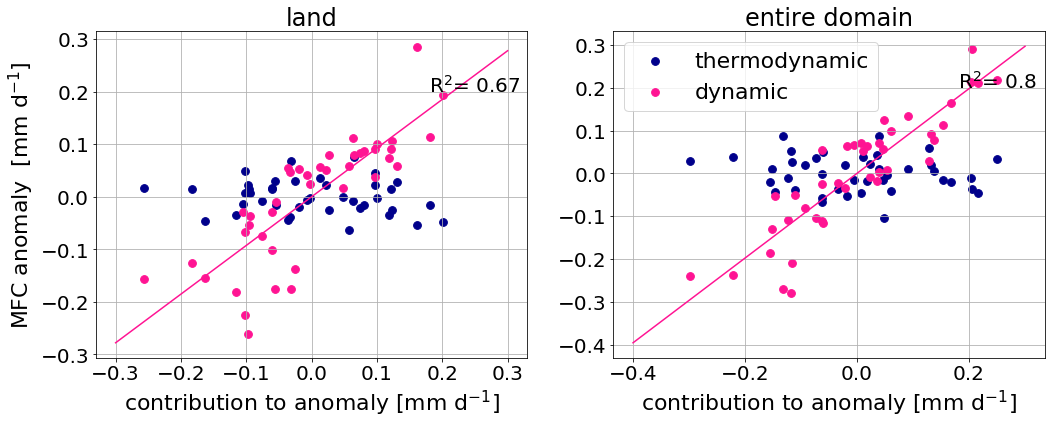

In [640]:
plt.figure(figsize= (17,6))
fs= 22

ax1= plt.subplot(1,2,1)
ax1.set_title('land')
ax1.scatter(-(moistdiv_land),thermodynamic_land, label = 'thermodynamic', color = 'darkblue', s=60)
ax1.scatter(-(moistdiv_land), dynamic_land, label = 'dynamic', color = 'deeppink' ,s= 60)
x= ax1.get_xticks()
ax1.plot(x,intercept_land + slope_land*x, color= 'deeppink')
ax1.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value_land**2, decimals=2)) )
# regession lines 


ax1.set_ylabel('MFC anomaly  [mm d$^{-1}$]', fontsize = fs)
ax1.set_xlabel('contribution to anomaly [mm d$^{-1}$]', fontsize= fs)
ax1.grid()

ax2= plt.subplot(1,2,2)
ax2.set_title('entire domain')
ax2.scatter(-(moistdiv),thermodynamic, label = 'thermodynamic', color = 'darkblue', s=60)
ax2.scatter(-(moistdiv), dynamic, label = 'dynamic', color = 'deeppink',s= 60)
#ax2.set_ylabel('total moisture transport [mm d$^{-1}$]', fontsize = fs)
x= ax2.get_xticks()
ax2.plot(x,intercept + slope*x, color= 'deeppink')
ax2.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value**2, decimals=2)) )
ax2.set_xlabel('contribution to anomaly [mm d$^{-1}$]', fontsize= fs)
ax2.grid()

plt.legend(fontsize= fs)
plt.savefig('plots/thermo_dynam_scatterplot.png')

## test total water column integration 


The column integration function is tested here. Note that two important steps need to be done: 

1. setting z (q) values below surface pressure to 0 
2. convert units of specific humidity from kg/kg to kg/m3


**Alternatively:**
leave out second step and integrate over pressure levels instead

In [174]:
import atmotrans as atm

# total column water vapor and divergence
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)
tcwv = d.tcwv[0].values

# specific humidity 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_uvspecific_humidity_60,50,10,130.nc'
sh = xr.open_dataset(f)
q = sh.q[0].values

# geopotential
f = 'cache/era5_1979_may.nc'
z = xr.open_dataset(f)
z = z.z[0].values

# surface pressure 
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
sp = xr.open_dataset(f)
sp = sp.sp[0].values / 100

# temperature 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
te = xr.open_dataset(f)
t = te.t[0].values

pressure = sh.level.values 

In [ ]:
from pansat.products.reanalysis.

In [189]:
help(era5)

Help on module pansat.products.reanalysis.era5 in pansat.products.reanalysis:

NAME
    pansat.products.reanalysis.era5

DESCRIPTION
    pansat.products.reanalysis.era5
    This module defines the ERA5 product class, which represents all
    supported ERA5 products.

CLASSES
    builtins.Exception(builtins.BaseException)
        NoAvailableProviderError
    pansat.products.product.Product(abc.ABC)
        ERA5Product
    
    class ERA5Product(pansat.products.product.Product)
     |  The ERA5 class defines a generic interface for ERA5 products.
     |  
     |  
     |  Attributes:
     |      tsteps(``str``): "monthly" or "hourly" to choose resolution of output timesteps
     |      levels(``str``): "surface", "pressure" or "land". <surface> contains surface data
     |                        and column-integrated values, pressure levels contains data throughout
     |                        the atmosphere column and <land> contains data from surface to soil depth
     |      name(``s

In [175]:
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)


In [176]:
# set z to 0 where surface pressure< 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = atm.find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1   
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] =  0

In [651]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] = q[plev]* p_d

In [177]:
# column integration of q 
q_integrated = atm.column_integration(np.flip(q, axis= 0), np.flip(z, axis = 0), ax = 0)

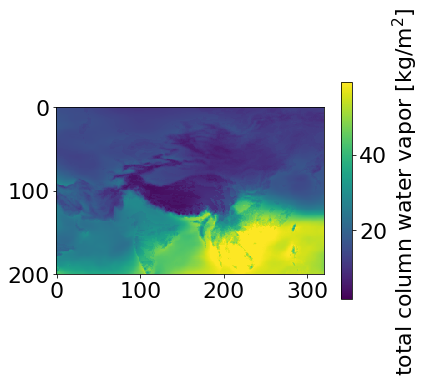

In [178]:
plt.imshow(q_integrated, vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_calculated.png')
plt.show()

## Column-integration over pressure levels 

In [90]:
def colint_pressure(values,pressure_levels):
    return np.trapz(values, pressure_levels, axis = 0)* g


In [112]:
# get 3D field from pressure values 
stack= np.array(201*[pressure])
surface_pressures= np.array(321*[stack]).T


In [160]:
# set values to 0 where surface pressure< 1000 hpa 
coords = np.where(sp < 1000)
for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = atm.find_nearest_idx(pressure, sp_value)
    # set q value below ground to 0 
    if sp_value <pl:
        idx = idx-1
    surface_pressures[idx:36, ilat, ilon] =  sp_value
    q[idx+1:36, ilat, ilon] =  0

In [179]:
q_integrated_pr= atm.column_integration(q, pressure*100)

In [183]:
colint= atm.colint_pressure(q, pressure)

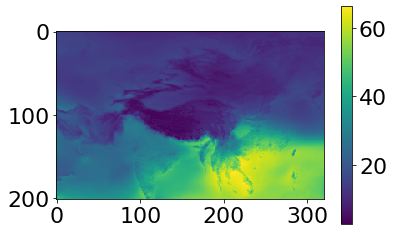

In [181]:
plt.imshow(q_integrated)
plt.colorbar()

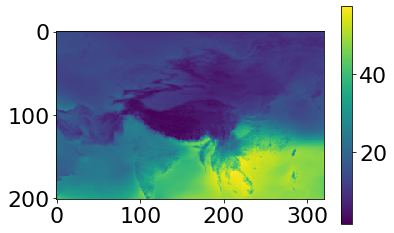

In [184]:
plt.imshow(colint)
plt.colorbar()

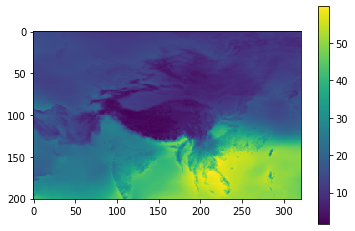

In [17]:
plt.imshow(q_integrated_pr)
plt.colorbar()

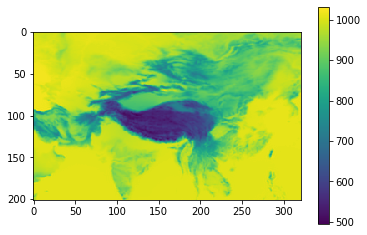

In [152]:
plt.imshow(sp)
plt.colorbar()

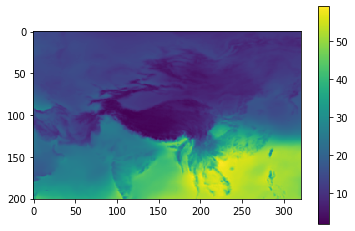

In [20]:
plt.imshow(tcwv)
plt.colorbar()

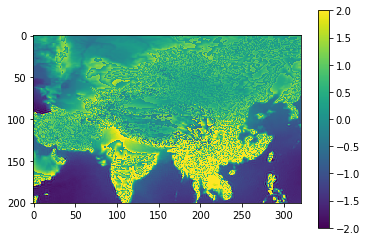

In [124]:
plt.imshow(q_integrated_pr- tcwv, vmin = -2, vmax= 2)
plt.colorbar()

In [137]:
colint= atm.colint_pressure(q, pressure)

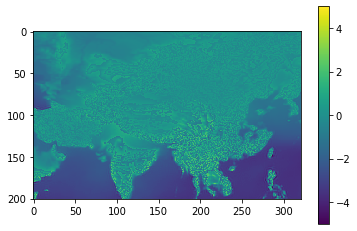

In [140]:
plt.imshow(colint - tcwv, vmin = -5, vmax= 5)
plt.colorbar()

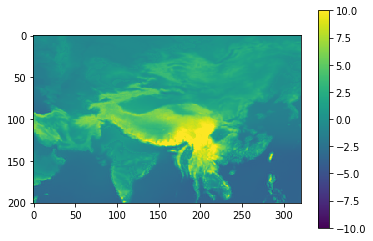

In [163]:
plt.imshow(colint - tcwv, vmin = -10, vmax= 10)
plt.colorbar()

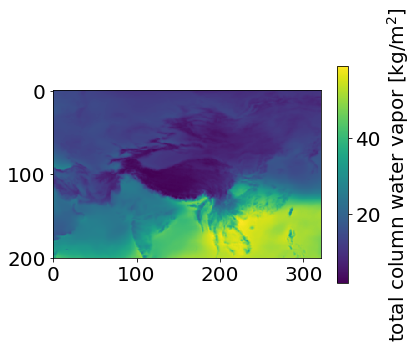

In [705]:
plt.imshow(tcwv,vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_output.png')
plt.show()